In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import os
import re

import scipy as sc

################################################
# Load in Factorial Experiment Data
################################################

base_path = "./factorial_experiment/results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-(?P<cov>\w+)-(?P<eps>[a-zA-Z0-9]+)_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_target(?P<target>\d+[.]\d+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file)
    file_data = re.match(file_expr, file).groupdict()
    file_df["cov"] = file_data["cov"]
    file_df["eps"] = file_data["eps"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["target"] = float(file_data["target"])
    file_df["seed"] = int(file_data["seed"])
    file_df["experiment_num"] = int(file_data["seed"][-3:])
    file_dfs.append(file_df)

factorial_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs

################################################
# Load in Sample Size Data
################################################

base_path = "./sample_size_experiment/results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-(?P<cov>\w+)-(?P<eps>[a-zA-Z0-9]+)_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_target(?P<target>\d+[.]\d+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file)
    file_data = re.match(file_expr, file).groupdict()
    file_df["cov"] = file_data["cov"]
    file_df["eps"] = file_data["eps"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["target"] = float(file_data["target"])
    file_df["seed"] = int(file_data["seed"])
    file_df["experiment_num"] = int(file_data["seed"][-3:])
    file_dfs.append(file_df)

sample_size_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs


################################################
# Create the colors and names of the methods
################################################

rename_dict = {
    "OLS__L1" : "OLS-L1",
    "OLS__L2" : "OLS-L2",
    "OLS__Huber": "OLS-Huber",
    "Huber__L1": "Huber-L1",
    "Huber__L2": "Huber-L2",
    "Huber__Huber" : "Huber-Huber",
    "t-test" : "F-test"
}

factorial_df = factorial_df.rename(columns = rename_dict)
sample_size_df = sample_size_df.rename(columns = rename_dict)

plot_methods = [
    "OLS-L2",
    "Huber-L2",
    "OLS-Huber",
    "Huber-Huber",
    "OLS-L1",
    "Huber-L1"
]


In [2]:
colors_dict = {
    "OLS-L1" : "palegreen",
    "Huber-L1" : "green",
    "OLS-L2" : "blue",
    "Huber-L2" : "cyan",
    "OLS-Huber" : "orange",
    "Huber-Huber" : "red",
    "F-test" : "black"
}

trials = 1000
covs = ["Normal", "t3", "Cauchy", "BalancedAnova"]
epss = ["Normal", "t3", "Cauchy", "Multinomial", "LogNormal"]
ps = [2, 6, 16]
targets = [0, 20, 40, 60, 80, 95]

# For sample size simulations
designs = [("Normal", "Normal"),
           ("Normal", "t3"),
           ("Normal", "Cauchy"),
           ("Normal", "LogNormal"),
           ("Normal", "Multinomial"),
           ("Cauchy", "Normal"),
           ("Cauchy", "t3"),
           ("Cauchy", "Cauchy"),
           ("Cauchy", "LogNormal"),
           ("Cauchy", "Multinomial")
]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


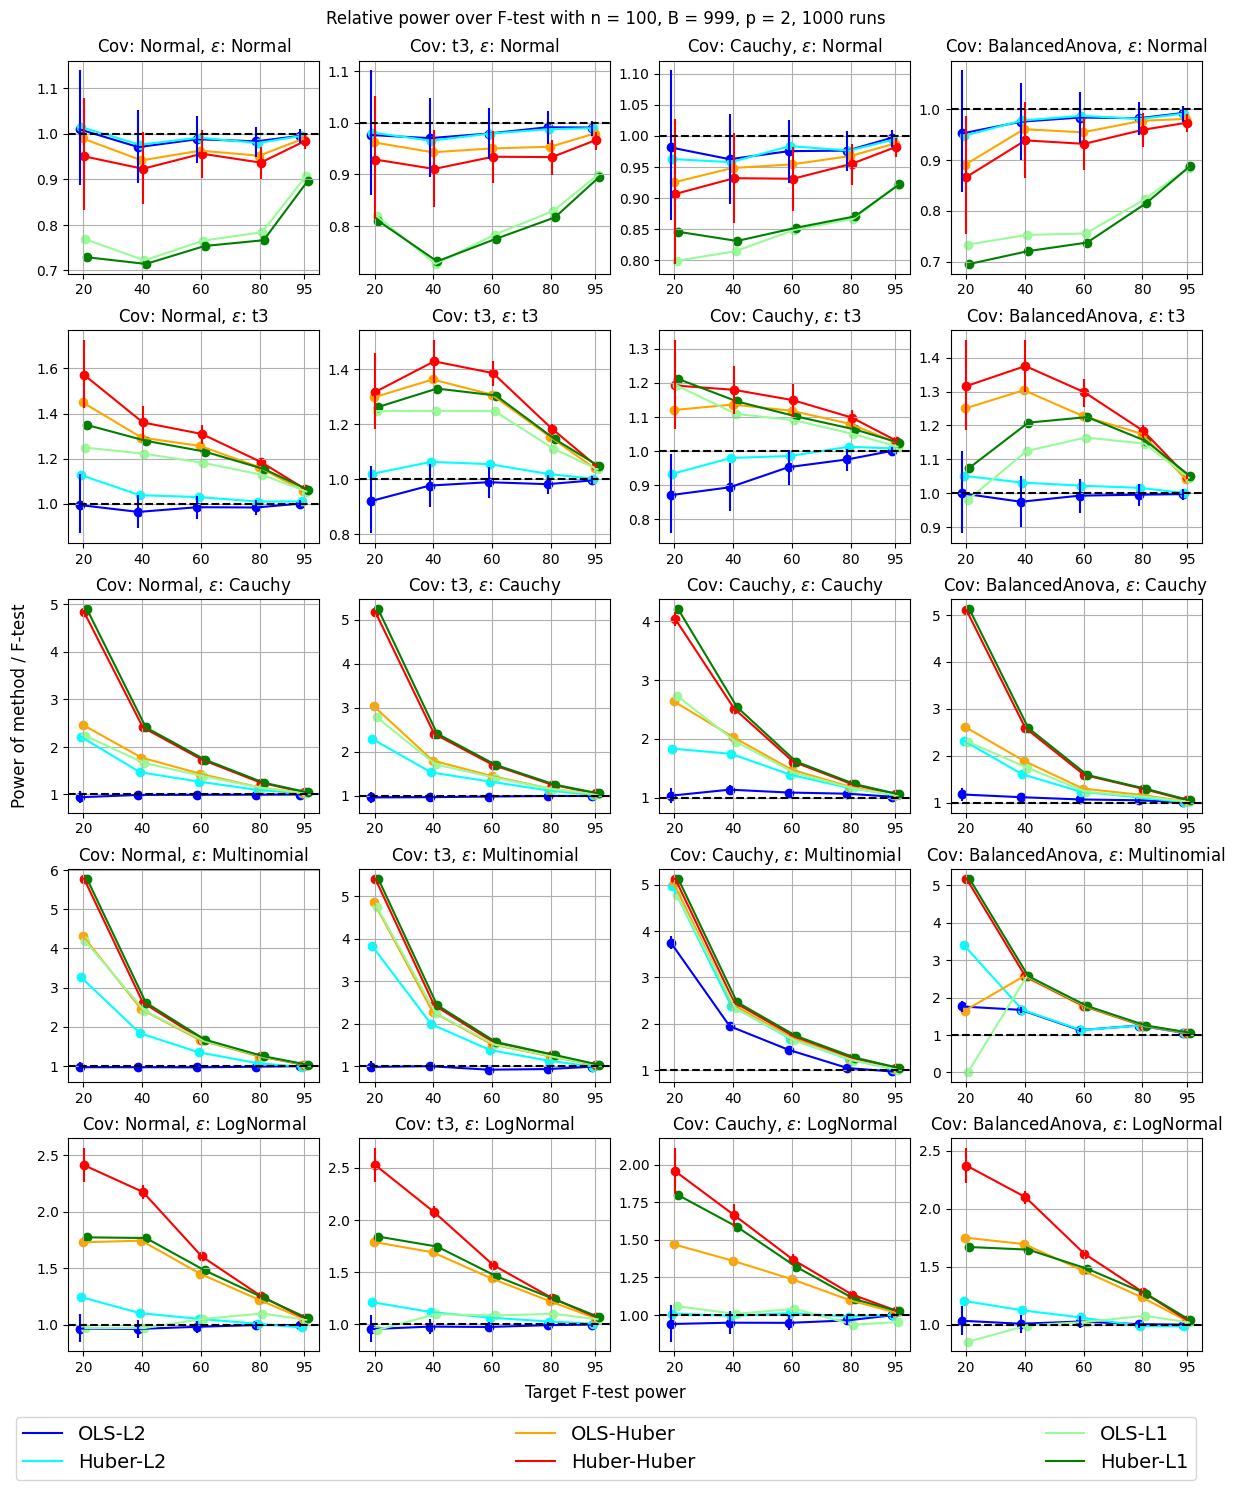

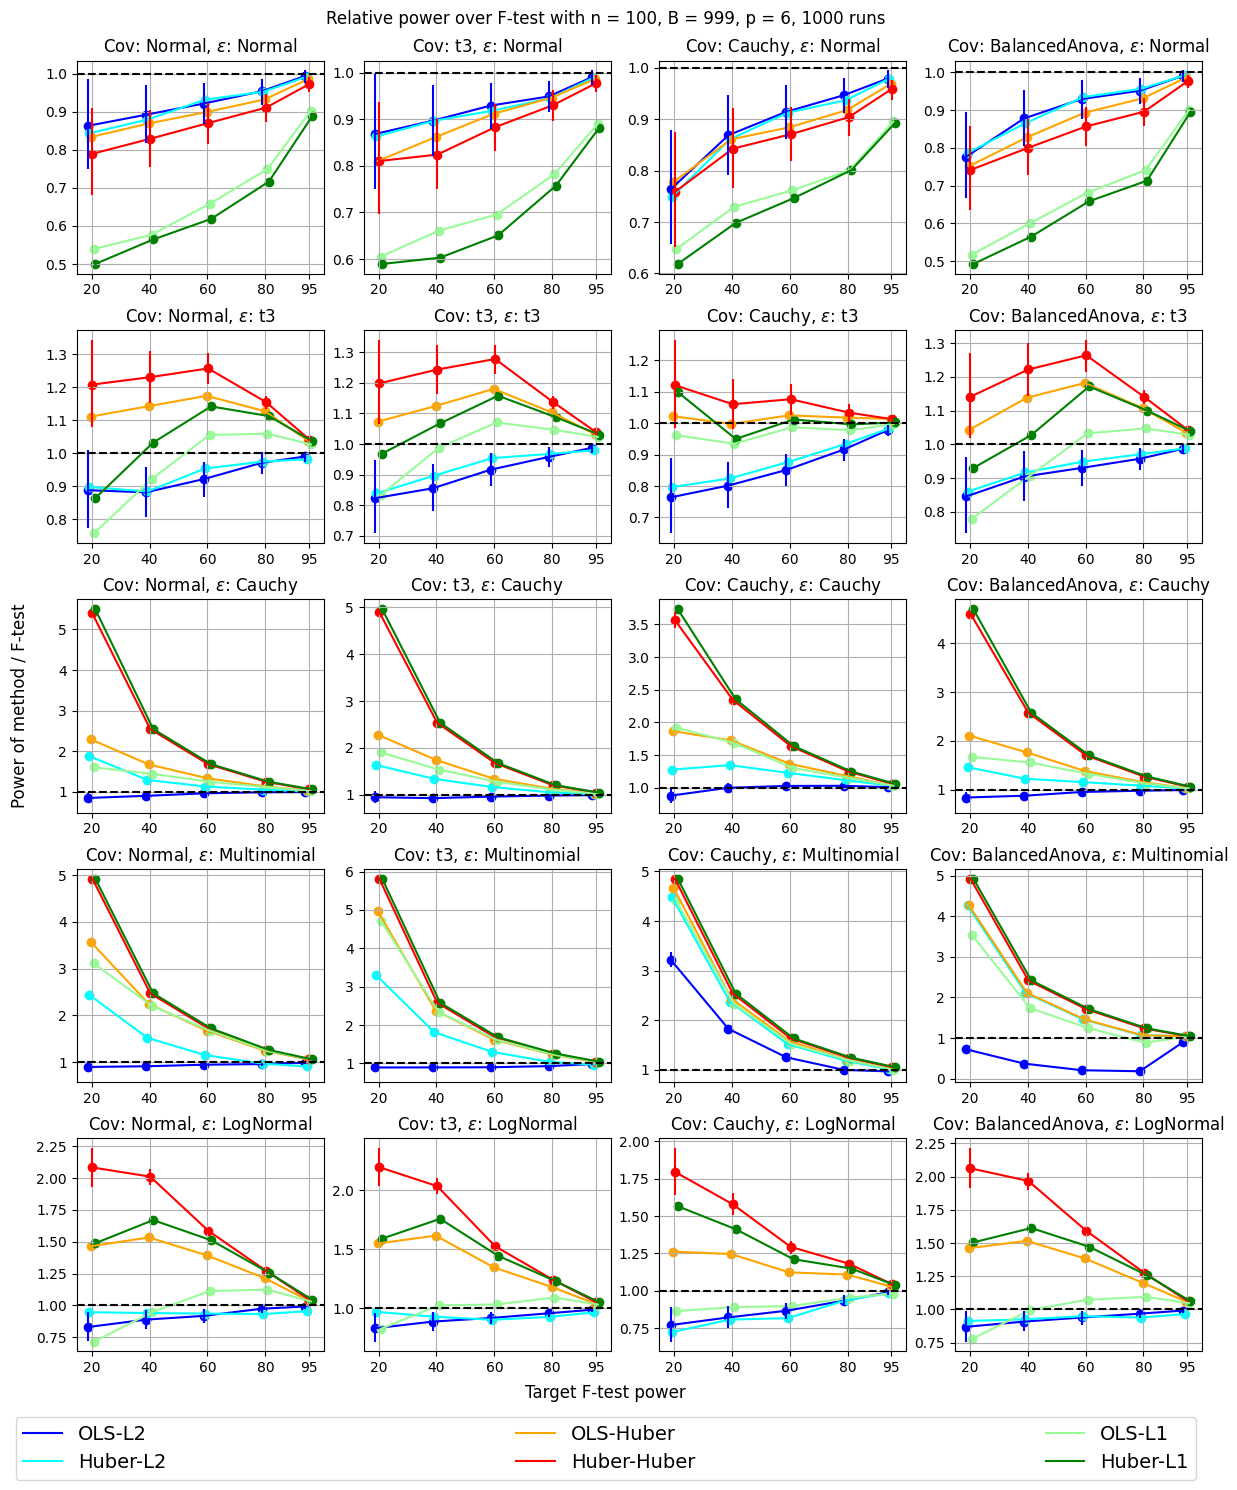

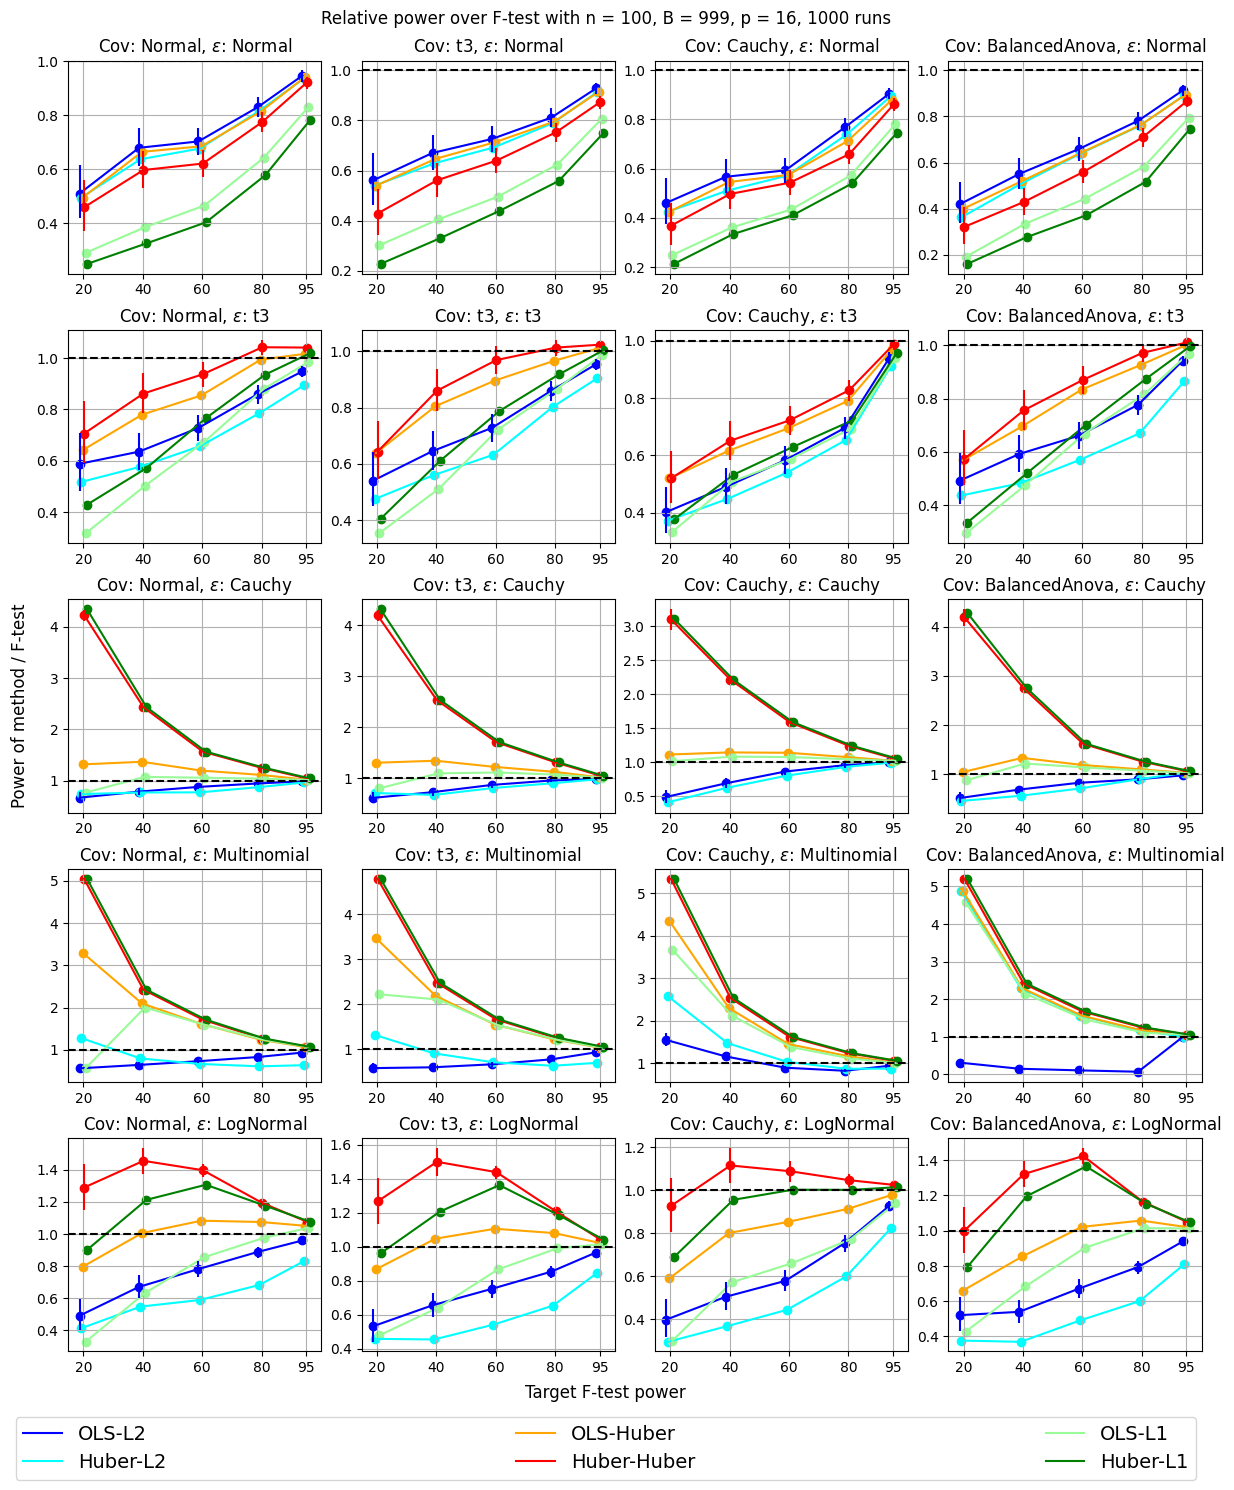

In [3]:
################################################
# Create the factorial experiment relative power plots
################################################

def plot_errorbars_for_method_power(ax, method_power, t_test_power, target_power, color, offset):
    # First compute exact binomial intervals
    counts_for_method = method_power * trials
    lower_bounds = sc.stats.beta.ppf(0.025,
        counts_for_method,
        trials - counts_for_method + 1)
    lower_bounds[np.isnan(lower_bounds)] = 0.

    upper_bounds = sc.stats.beta.ppf(0.975,
        counts_for_method + 1,
        trials - counts_for_method)
    upper_bounds[np.isnan(upper_bounds)] = 1.

    # Adjust the bounds to the relative plot
    lower_bounds = lower_bounds / t_test_power
    upper_bounds = upper_bounds / t_test_power

    # Plot the error bars using ax.errorbar method
    method_ratio = method_power / t_test_power
    ax.errorbar(
        target_power + offset,
        method_ratio,
        yerr = (method_ratio - lower_bounds, upper_bounds - method_ratio),
        xerr = None,
        color = color,
        ls = "none"
    )
    
def plot_factorial_cell(ax, cov, eps, p):
    cov_mask = factorial_df["cov"] == cov
    eps_mask = factorial_df["eps"] == eps
    p_mask = factorial_df["p"] == p

    df = factorial_df[cov_mask & eps_mask & p_mask][["target", "F-test"] + plot_methods]
    power_by_target = df.groupby("target").aggregate(lambda x: np.mean(x <= 0.05)).reset_index()

    # Do not plot the Type I error rate
    power_by_target = power_by_target[power_by_target["target"] != 0]

    # On x-axis, jitter target power for readability
    for index, method in enumerate(plot_methods):
        ax.plot(
            power_by_target["target"] + (index - 2.5)/2,
            power_by_target[method]/power_by_target["F-test"],
            label = method,
            color = colors_dict[method])
        ax.scatter(
            power_by_target["target"] + (index - 2.5)/2,
            power_by_target[method]/power_by_target["F-test"],
            color = colors_dict[method])

    plot_errorbars_for_method_power(ax,
        power_by_target["OLS-L2"],
        power_by_target["F-test"],
        power_by_target["target"],
        colors_dict["OLS-L2"],
        offset = (0 - 2.5)/2
    )

    plot_errorbars_for_method_power(ax,
        power_by_target["Huber-Huber"],
        power_by_target["F-test"],
        power_by_target["target"],
        colors_dict["Huber-Huber"],
        offset = (3 - 2.5)/2
    )


    ax.set_title(f"Cov: {cov}, $\\epsilon$: {eps}")

    ax.set_xticks(power_by_target["target"])
    ax.grid(True)

    ax.axhline(y = 1., ls = "--", color = "black")

for p in ps:
    fig = plt.figure(layout="constrained", figsize = (12, 14))
    axs = fig.subplots(nrows = 5, ncols = 4)

    fig.supxlabel("Target F-test power")
    fig.supylabel("Power of method / F-test")
    fig.suptitle(f"Relative power over F-test with n = 100, B = 999, p = {p}, 1000 runs")
        
    for i, cov in enumerate(covs):
        for j, eps in enumerate(epss):
            plot_factorial_cell(axs[j][i], cov, eps, p)

    # Create the legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, mode = "expand", ncols = 3, 
        loc = "lower left", bbox_to_anchor = (0., -0.06, 1., 1.), fontsize = 14)

    # Save the figure
    fig.savefig(f"./images/sim_n100_p{p}_rel_power.eps", dpi = 800, bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


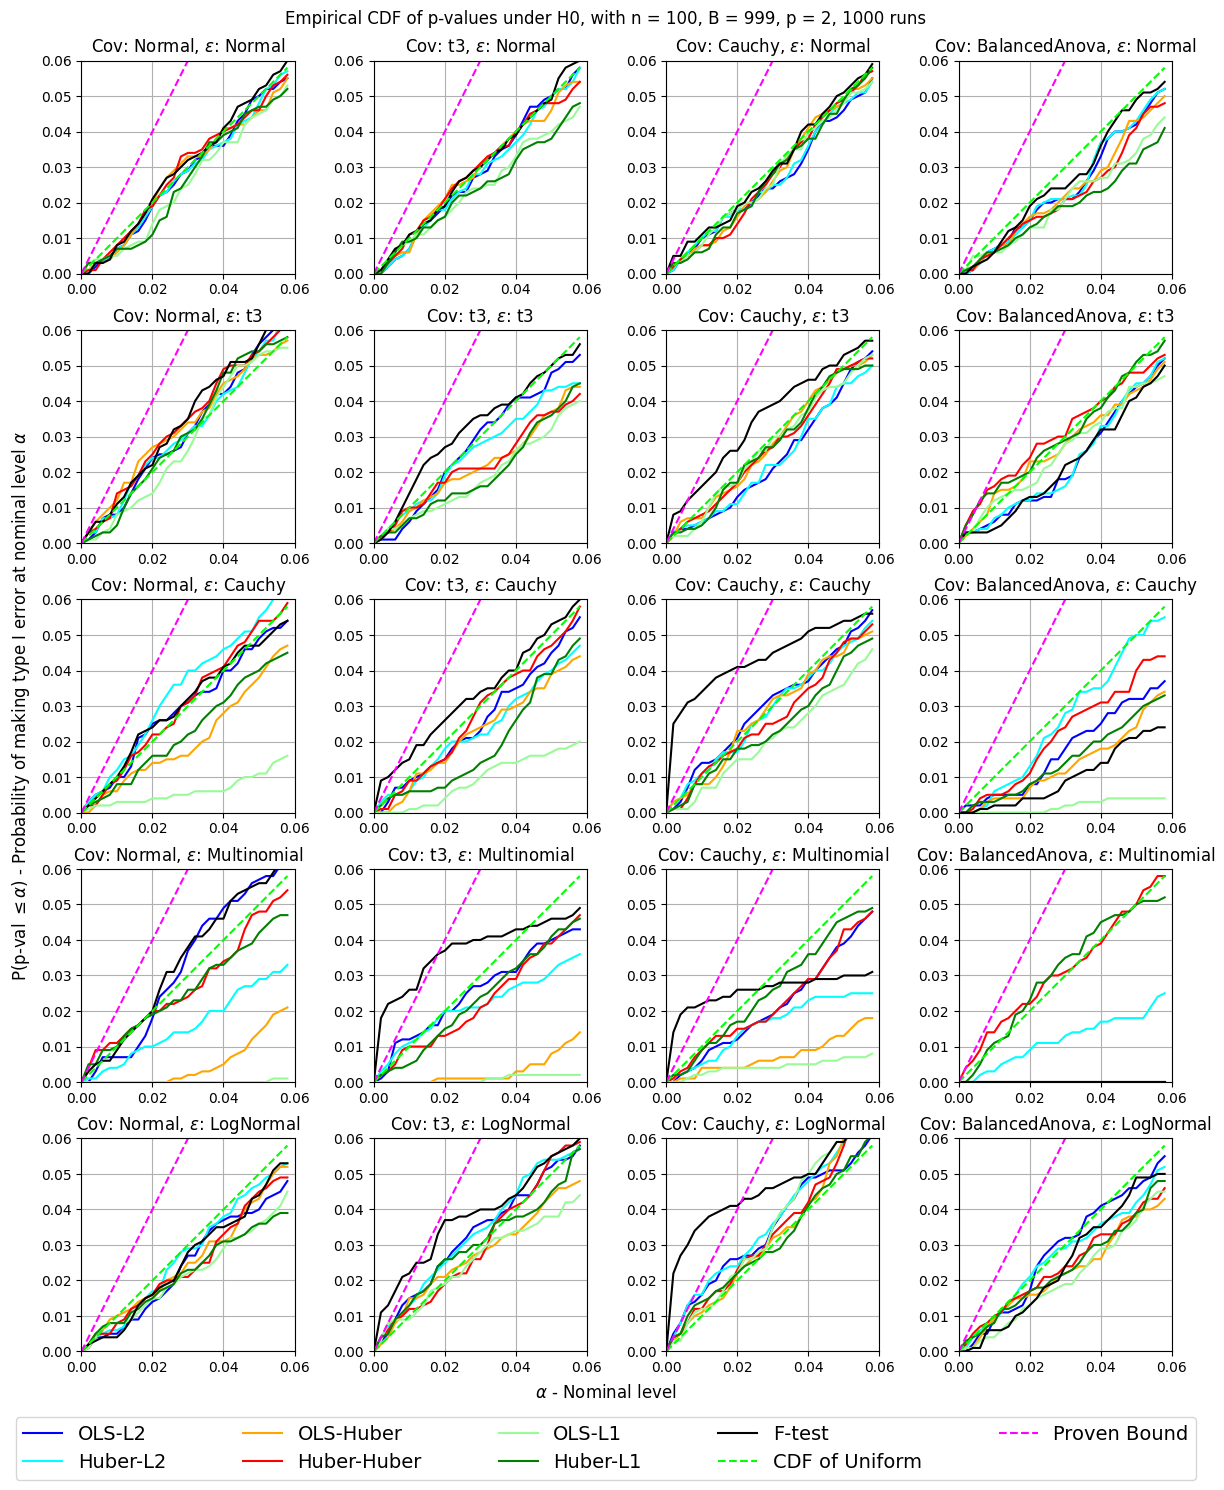

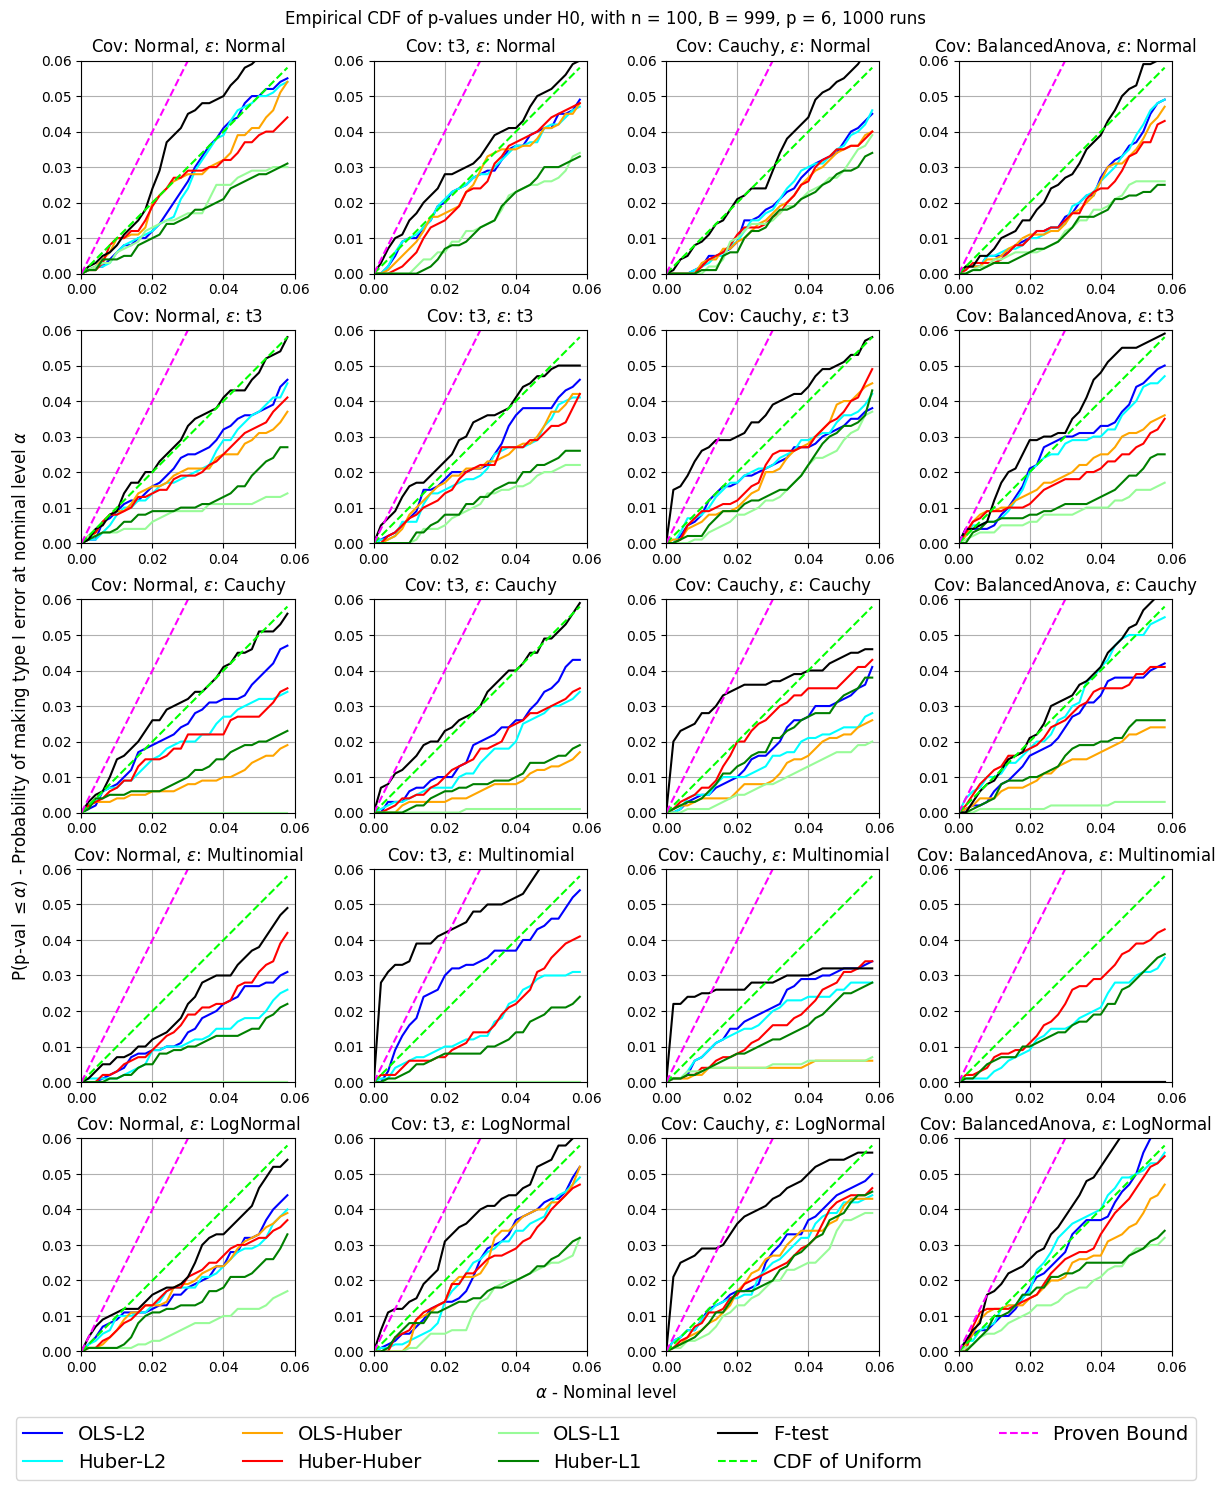

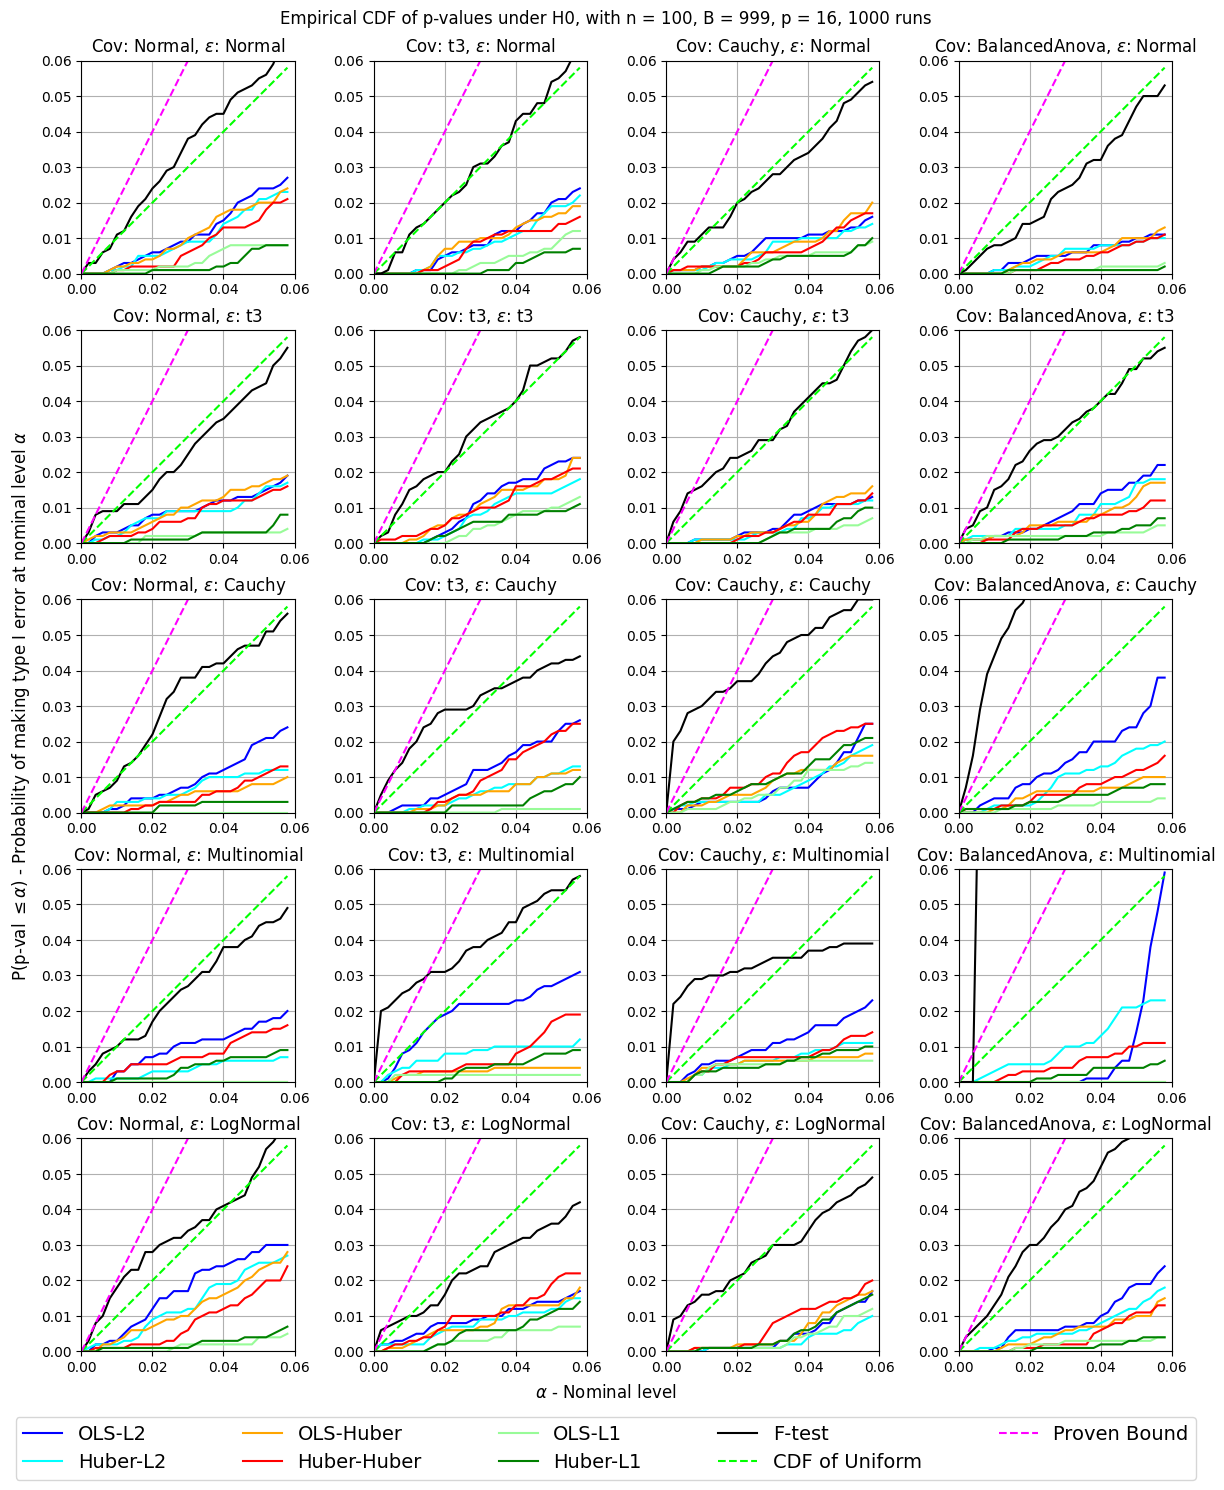

In [4]:

################################################
# Create the factorial experiment empirical CDF plots
################################################

for p in ps:
    fig = plt.figure(layout="constrained", figsize = (12, 14))
    axs = fig.subplots(nrows = 5, ncols = 4)

    fig.supxlabel("$\\alpha$ - Nominal level")
    fig.supylabel("P(p-val $\leq \\alpha$) - Probability of making type I error at nominal level $\\alpha$")
    fig.suptitle(f"Empirical CDF of p-values under H0, with n = 100, B = 999, p = {p}, 1000 runs")


    def plot_factorial_typeI_cell(ax, cov, eps, p):
        cov_mask = factorial_df["cov"] == cov
        eps_mask = factorial_df["eps"] == eps
        p_mask = factorial_df["p"] == p
        target_mask = factorial_df["target"] == 0

        df = factorial_df[cov_mask & eps_mask & p_mask & target_mask][plot_methods + ["F-test"]]

        M = 500
        indices = np.arange(M) / M

        max_alpha = 0.06

        trials_plotting_count = int(M * max_alpha)
        plot_mask = np.arange(trials_plotting_count)

        for col in df:
            empirical_cdf = (df[col].to_numpy().reshape(1, -1) <= indices.reshape(-1, 1)).mean(axis = 1)
            ax.plot(
                indices[plot_mask],
                empirical_cdf[plot_mask],
                label = col,
                color = colors_dict[col]
            )
        ax.plot(indices[plot_mask], indices[plot_mask], "--", color = "lime", label = "CDF of Uniform")
        ax.plot(indices[plot_mask], indices[plot_mask] * 2, "--", color = "fuchsia", label = "Proven Bound")

        ax.grid(True)
        ax.set_xlim(0.0, max_alpha)
        ax.set_ylim(0.0, max_alpha)
        ax.set_aspect("equal")

        ax.set_title(f"Cov: {cov}, $\\epsilon$: {eps}")

        
    for i, cov in enumerate(covs):
        for j, eps in enumerate(epss):
            plot_factorial_typeI_cell(axs[j][i], cov, eps, p)


    # Create the legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, mode = "expand", ncols = 5, 
        loc = "lower left", bbox_to_anchor = (0., -0.06, 1., 1.), fontsize = 14)

    # Save the figure
    fig.savefig(f"./images/sim_n100_p{p}_typeI.eps", dpi = 800, bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


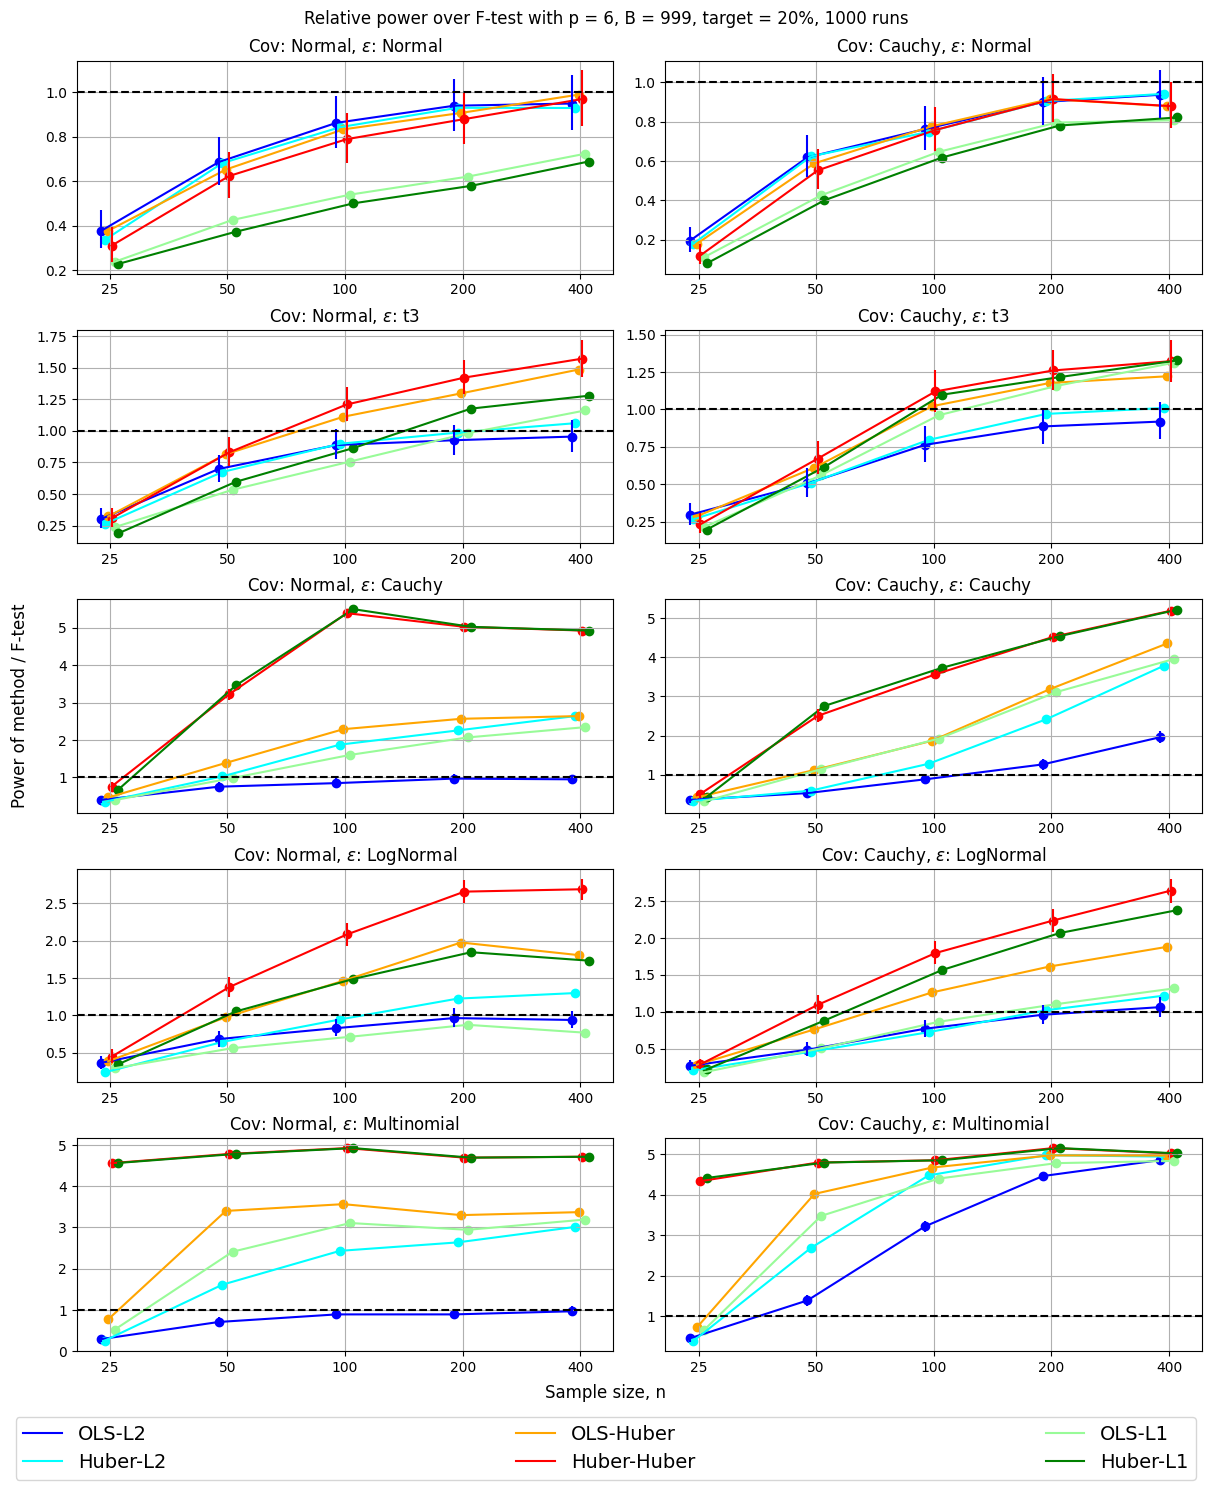

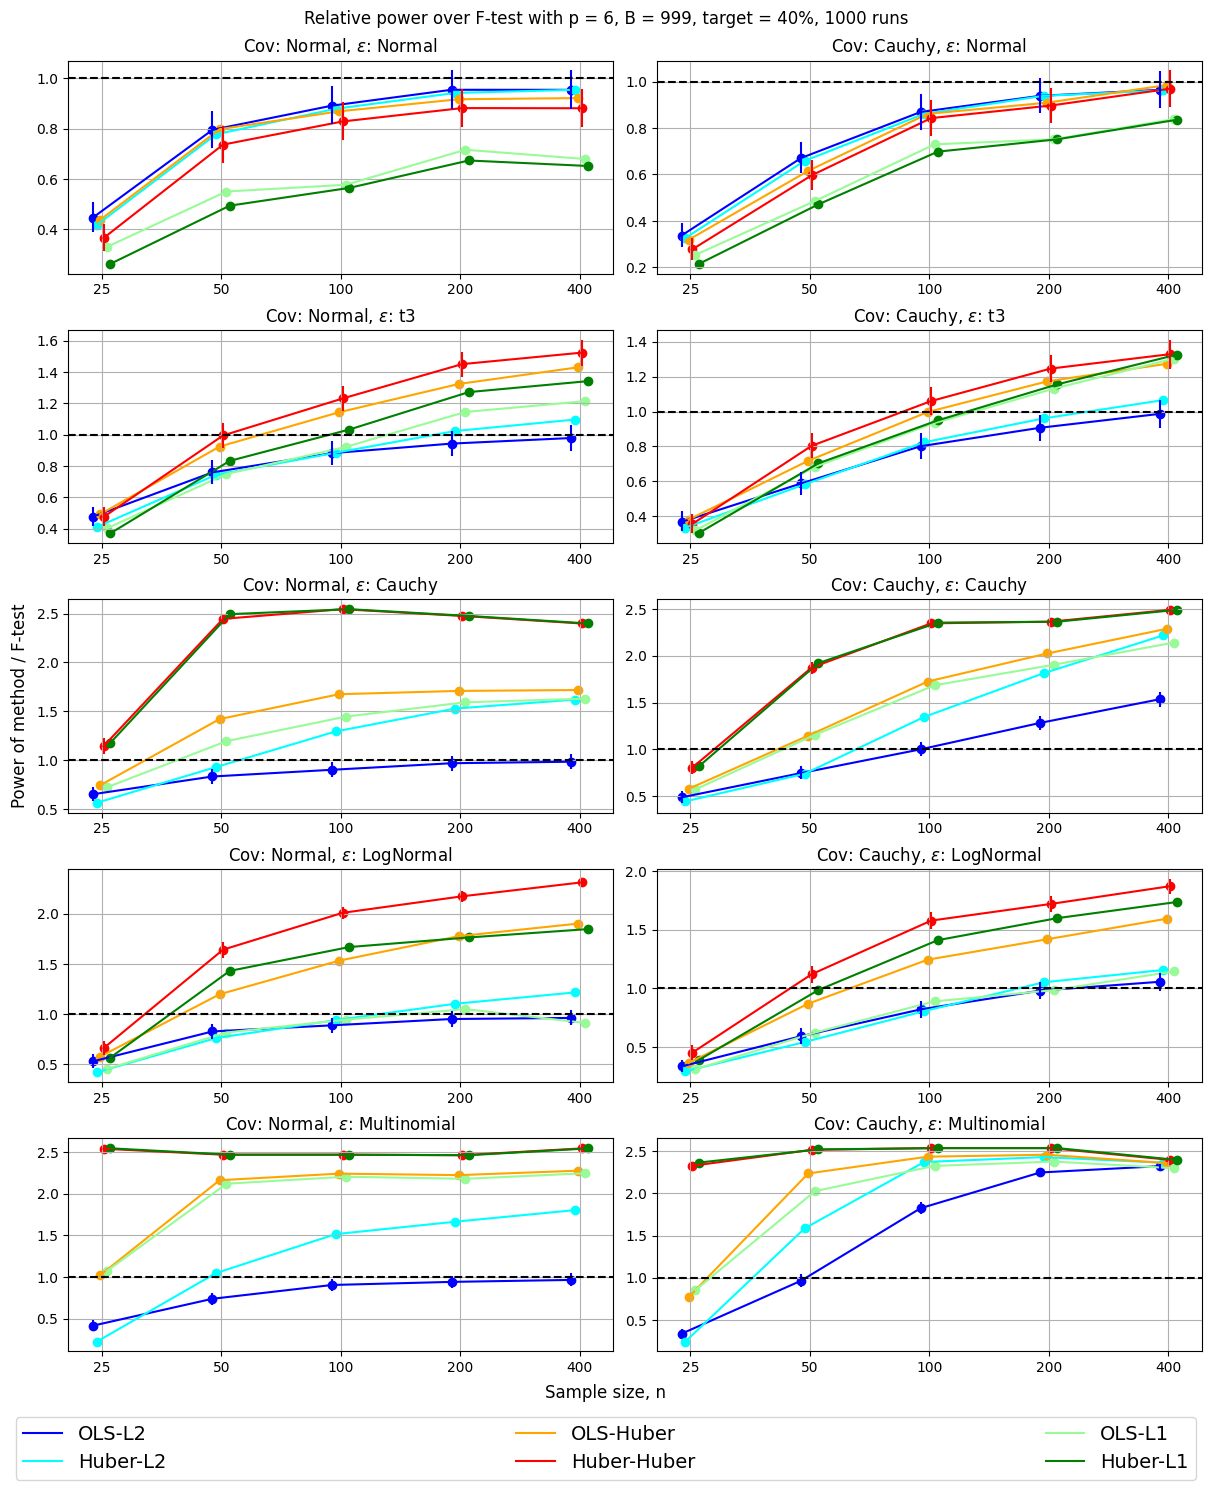

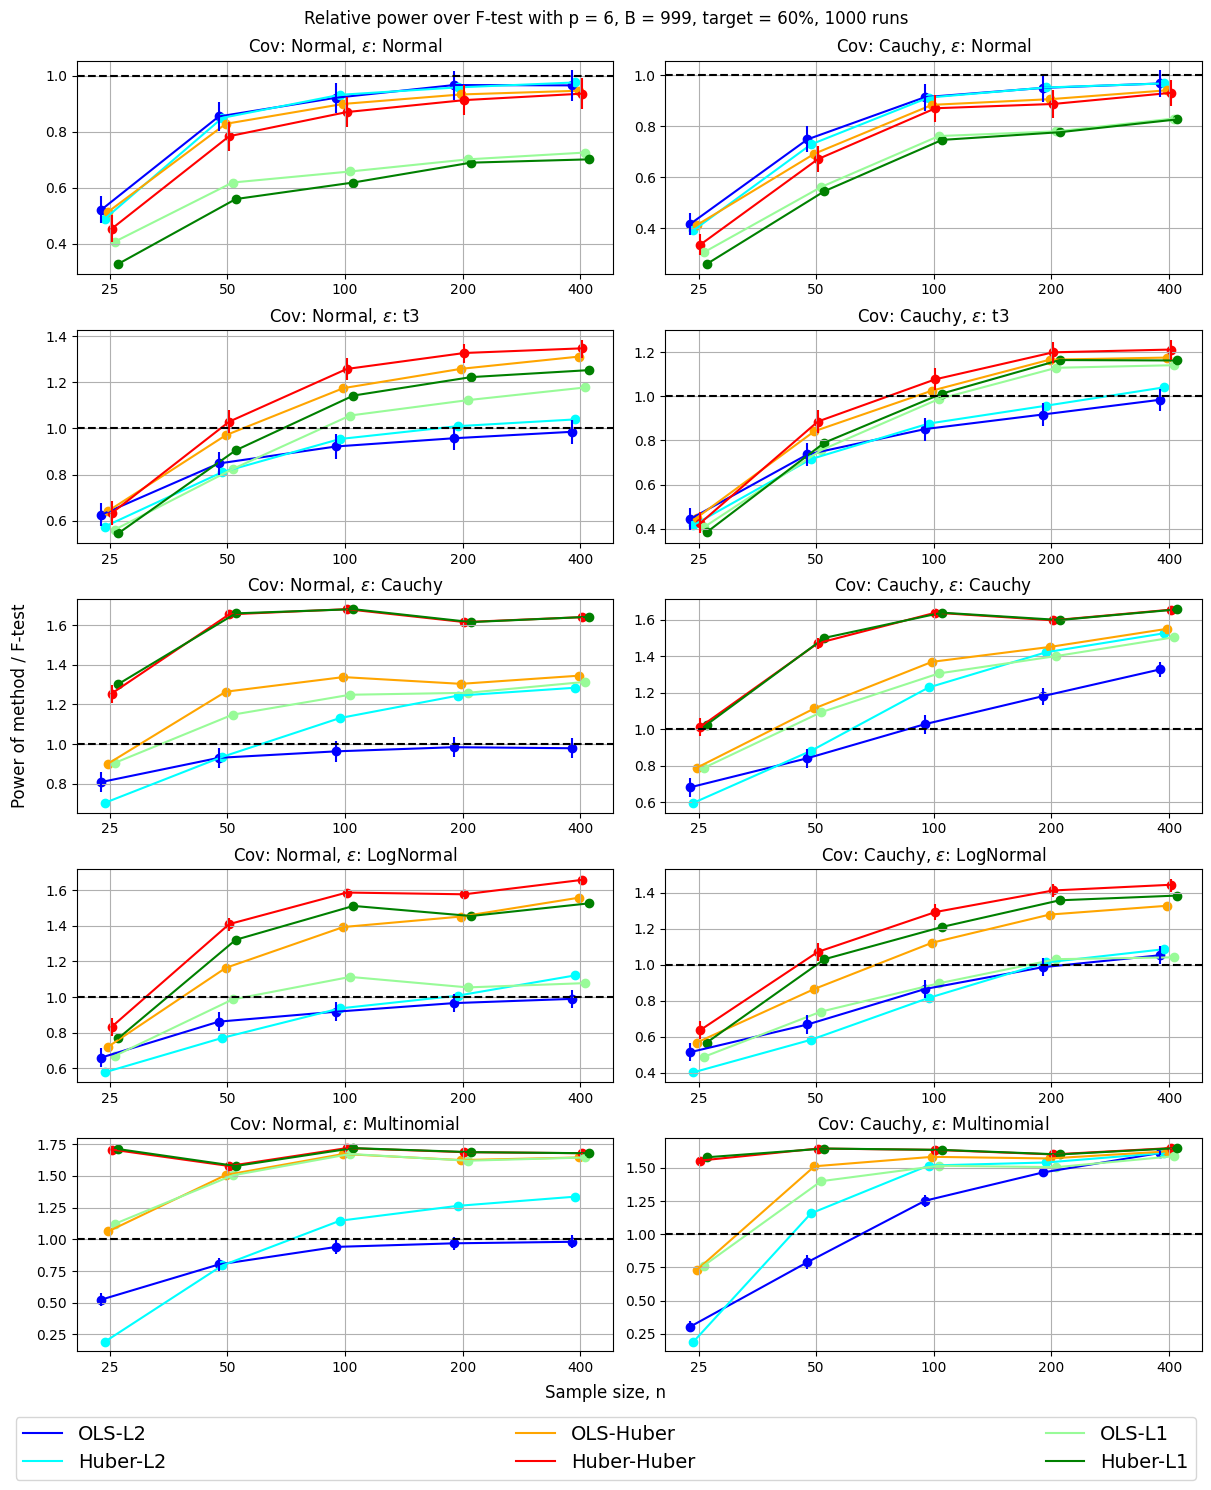

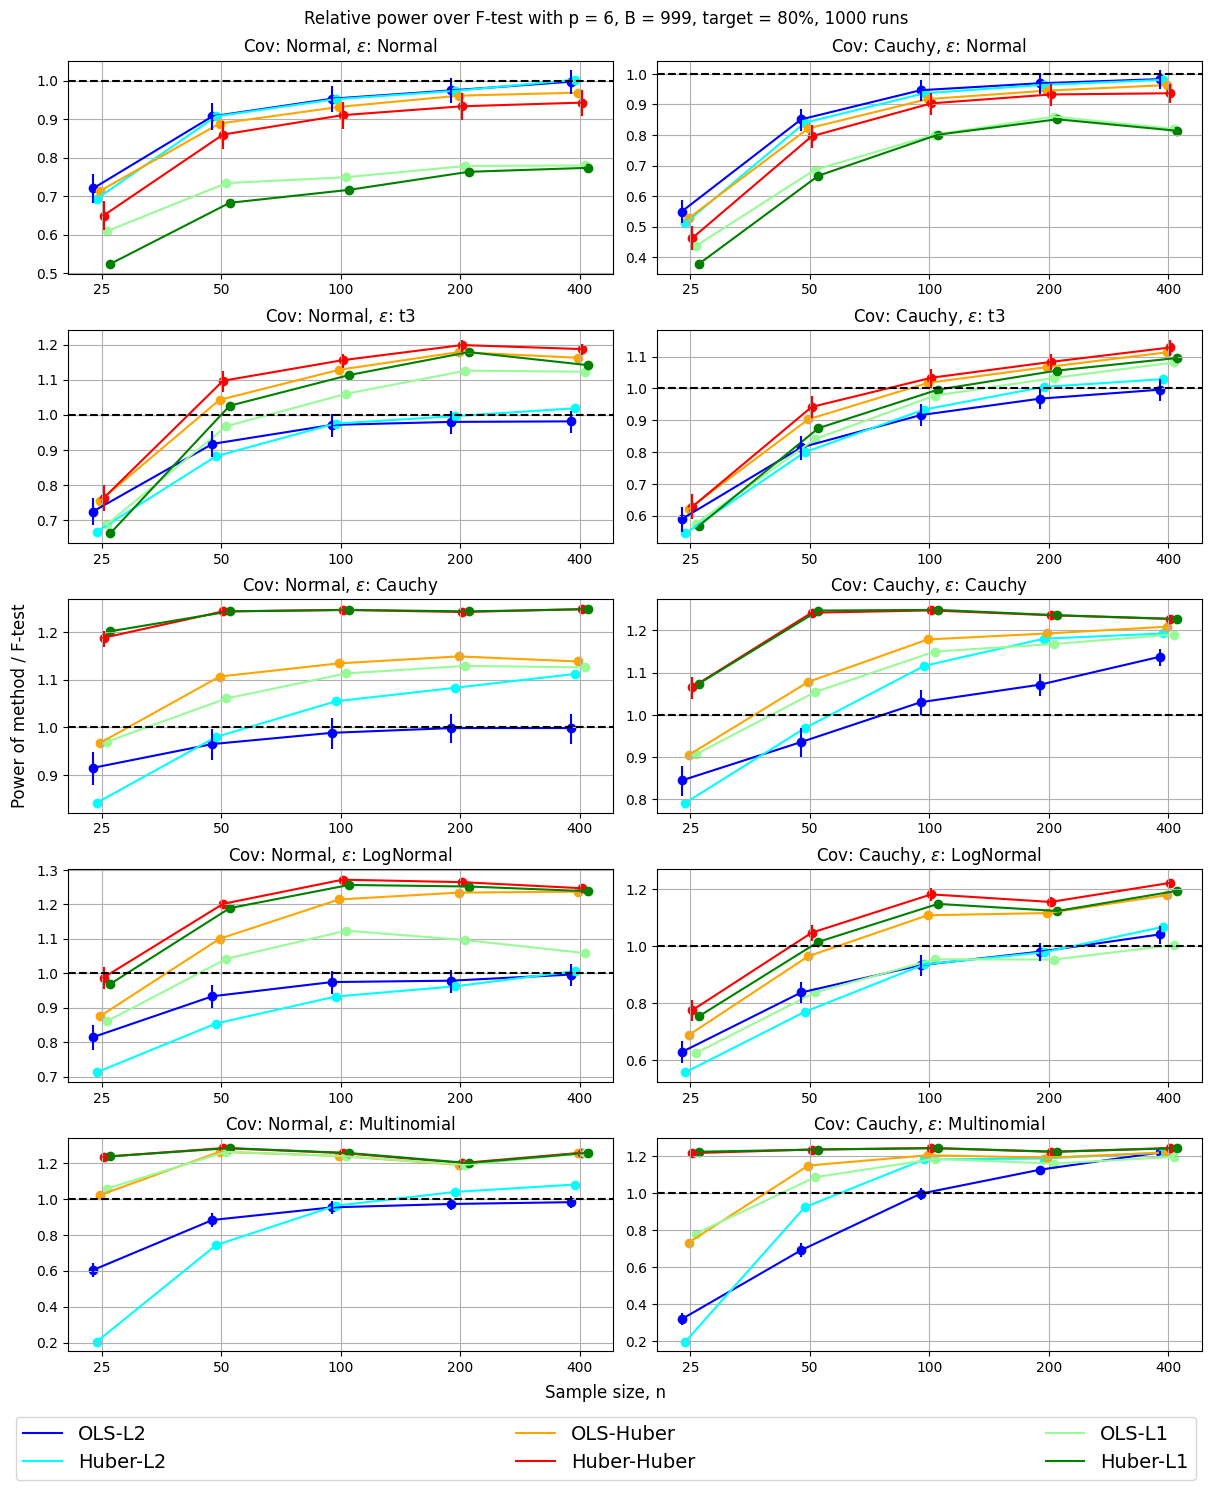

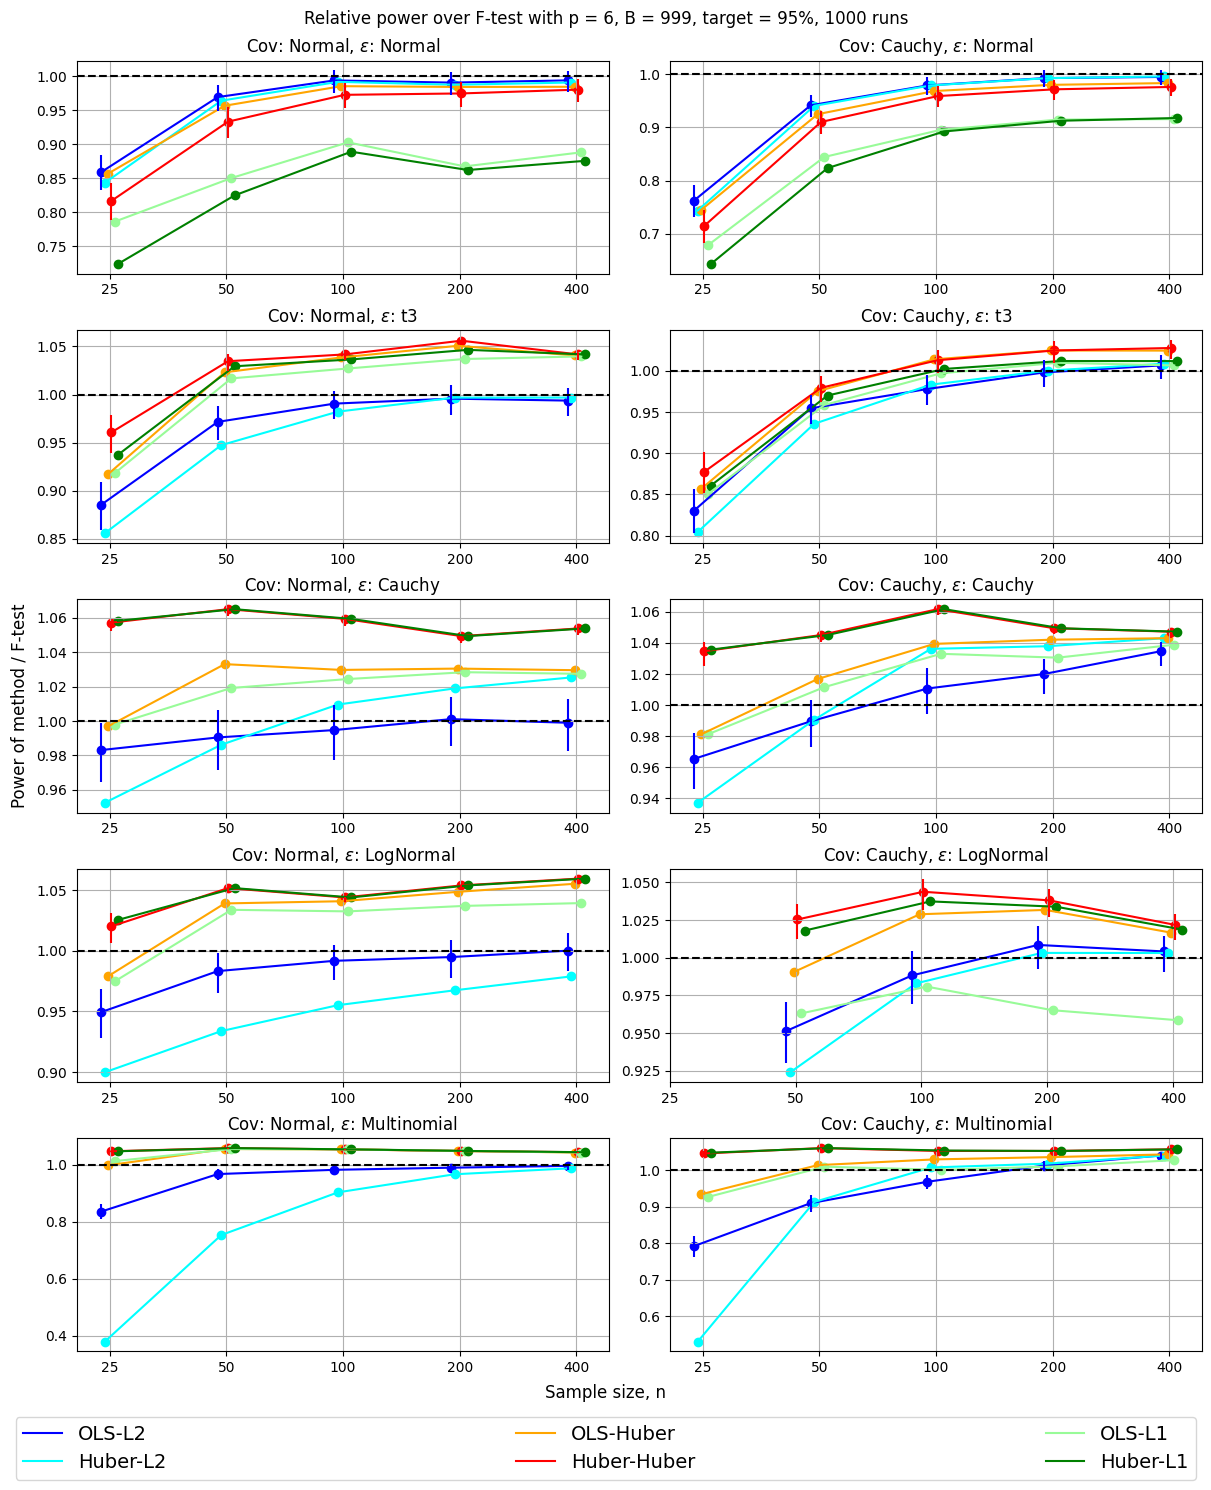

In [5]:
################################################
# Create the sample size experiment relative power plots
################################################

def plot_errorbars_for_method_power_sample_size(ax, method_power, F_test_power, n_values, color, offset):
    # First compute exact binomial intervals
    counts_for_method = method_power * trials
    lower_bounds = sc.stats.beta.ppf(0.025,
        counts_for_method,
        trials - counts_for_method + 1)
    lower_bounds[np.isnan(lower_bounds)] = 0.

    upper_bounds = sc.stats.beta.ppf(0.975,
        counts_for_method + 1,
        trials - counts_for_method)
    upper_bounds[np.isnan(upper_bounds)] = 1.

    # Adjust the bounds to the relative plot
    lower_bounds = lower_bounds / F_test_power
    upper_bounds = upper_bounds / F_test_power

    # Plot the error bars using ax.errorbar method
    method_ratio = method_power / F_test_power
    ax.errorbar(
        n_values * (1 + offset),
        method_ratio,
        yerr = (method_ratio - lower_bounds, upper_bounds - method_ratio),
        xerr = None,
        color = color,
        ls = "none"
    )

def plot_sample_size_cell(ax, cov, eps, target):
    cov_mask = sample_size_df["cov"] == cov
    eps_mask = sample_size_df["eps"] == eps
    target_mask = sample_size_df["target"] == target

    df = sample_size_df[cov_mask & eps_mask & target_mask][plot_methods + ["F-test", "n"]]

    cov_mask = factorial_df["cov"] == cov
    eps_mask = factorial_df["eps"] == eps
    target_mask = factorial_df["target"] == target
    p_mask = factorial_df["p"] == 6

    sample_size_from_factorial = factorial_df[cov_mask & eps_mask & target_mask & p_mask][plot_methods + ["F-test"]]
    sample_size_from_factorial["n"] = 100

    df = pd.concat([
        df, sample_size_from_factorial
    ])

    df = df.loc[df["n"].isin([25, 50, 100, 200, 400])]

    power_by_target = df.groupby("n").aggregate(lambda x: np.mean(x <= 0.05)).reset_index()

    # On x-axis, jitter n values for readability
    for index, method in enumerate(plot_methods):
        ax.plot(
            power_by_target["n"] * (1 + (index - 2.5)/50),
            power_by_target[method]/power_by_target["F-test"],
            label = method,
            color = colors_dict[method])
        ax.scatter(
            power_by_target["n"] * (1 + (index - 2.5)/50),
            power_by_target[method]/power_by_target["F-test"],
            color = colors_dict[method])

    plot_errorbars_for_method_power_sample_size(ax,
        power_by_target["OLS-L2"],
        power_by_target["F-test"],
        power_by_target["n"],
        colors_dict["OLS-L2"],
        offset = (0 - 2.5)/50
    )

    plot_errorbars_for_method_power_sample_size(ax,
        power_by_target["Huber-Huber"],
        power_by_target["F-test"],
        power_by_target["n"],
        colors_dict["Huber-Huber"],
        offset = (3 - 2.5)/50
    )

    ax.set_title(f"Cov: {cov}, $\\epsilon$: {eps}")
    ax.set_xscale("log", base = 2)
    ax.set_xticks([25, 50, 100, 200, 400])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.axhline(y = 1.0, ls = "--", color = "black")
    ax.grid(True)

# targets[0] is 0%, skip Type I error rate
for target in targets[1:]:
    fig = plt.figure(layout="constrained", figsize = (12, 14))
    axs = fig.subplots(nrows = 5, ncols = 2)

    fig.supxlabel("Sample size, n")
    fig.supylabel("Power of method / F-test")
    fig.suptitle(f"Relative power over F-test with p = 6, B = 999, target = {target}%, 1000 runs")
    
    for i, (cov, eps) in enumerate(designs):
        row = i % 5
        col = i // 5
        plot_sample_size_cell(axs[row][col], cov, eps, target)

    # Create the legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, mode = "expand", ncols = 3, 
        loc = "lower left", bbox_to_anchor = (0., -0.06, 1., 1.), fontsize = 14)

    # Save the figure
    fig.savefig(f"./images/sim_target{target}_rel_power.eps", dpi = 800, bbox_inches = "tight")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


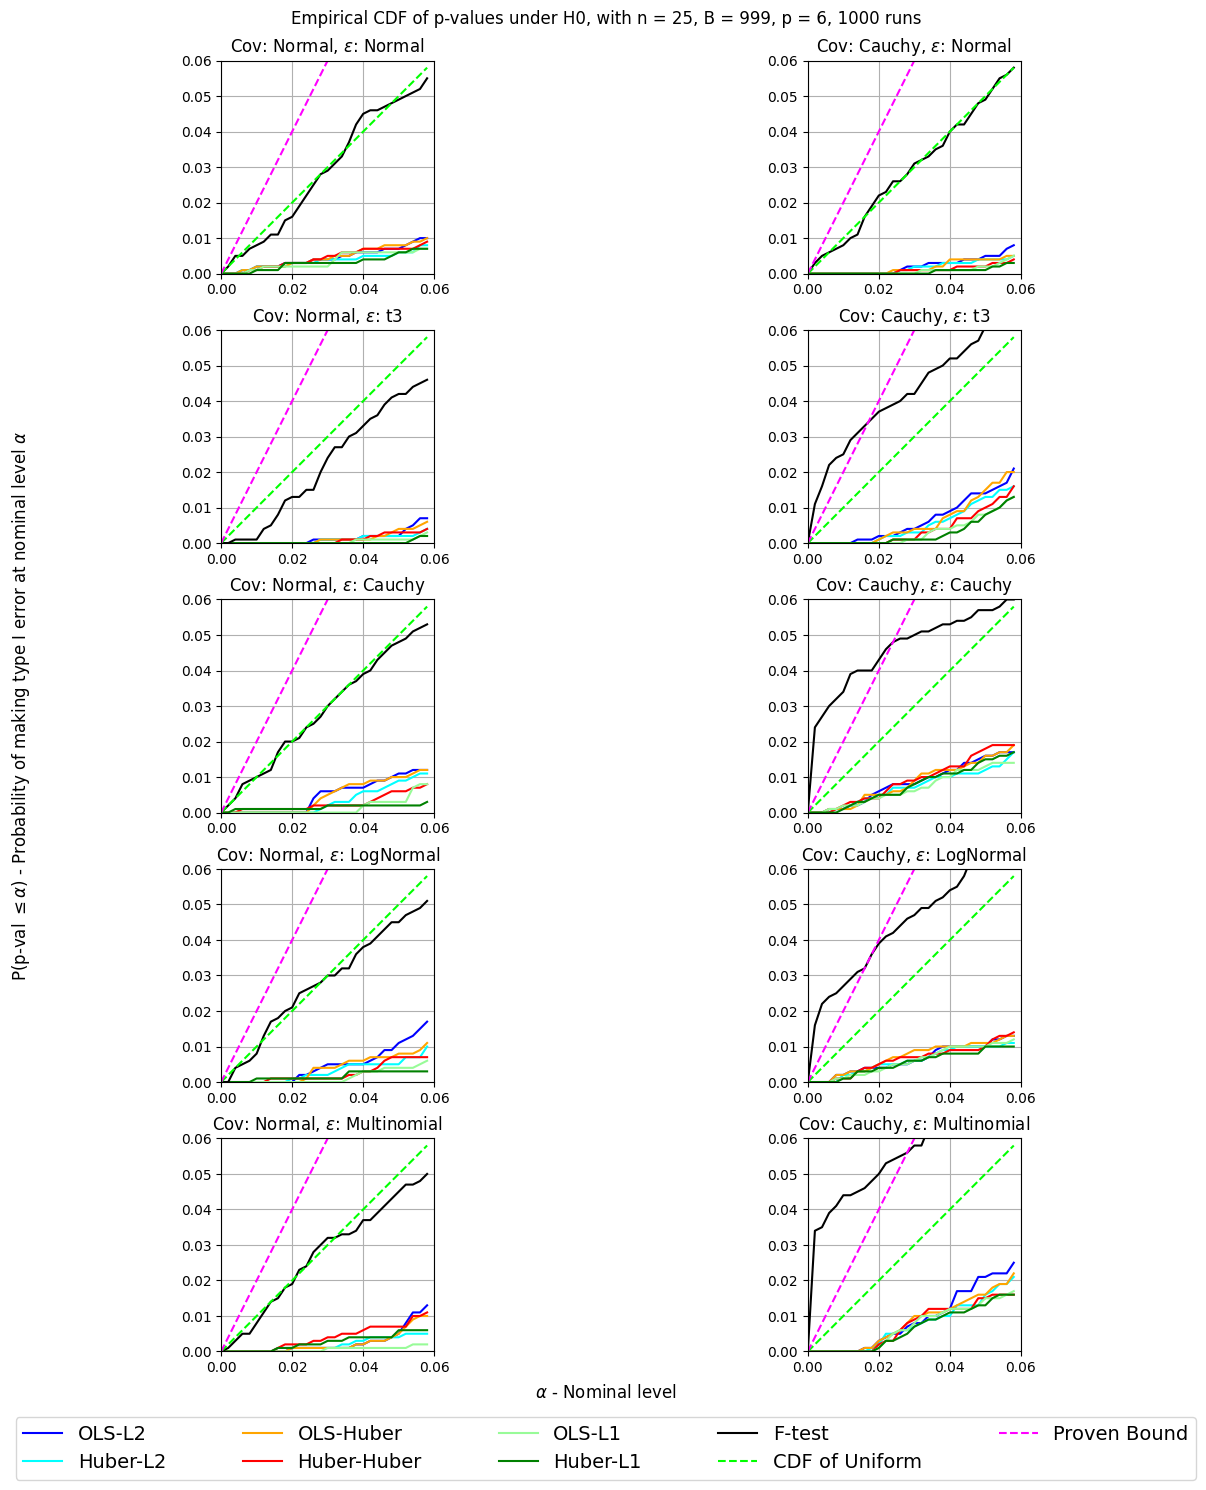

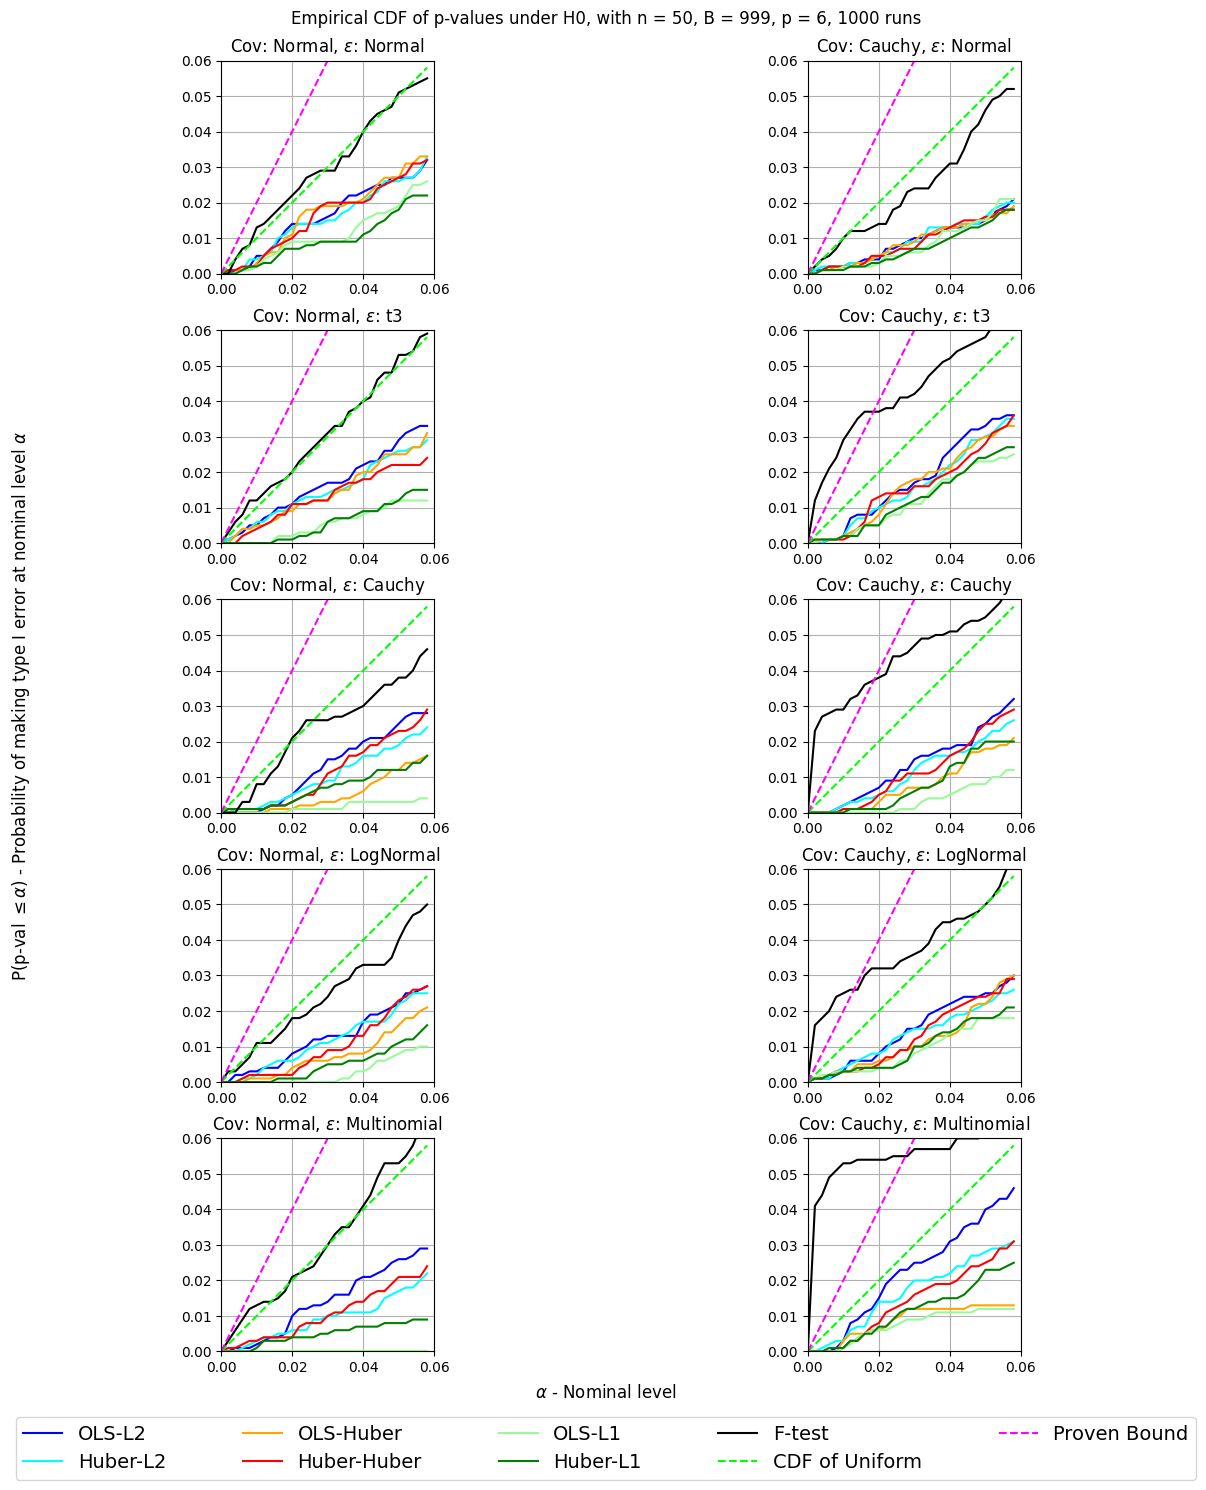

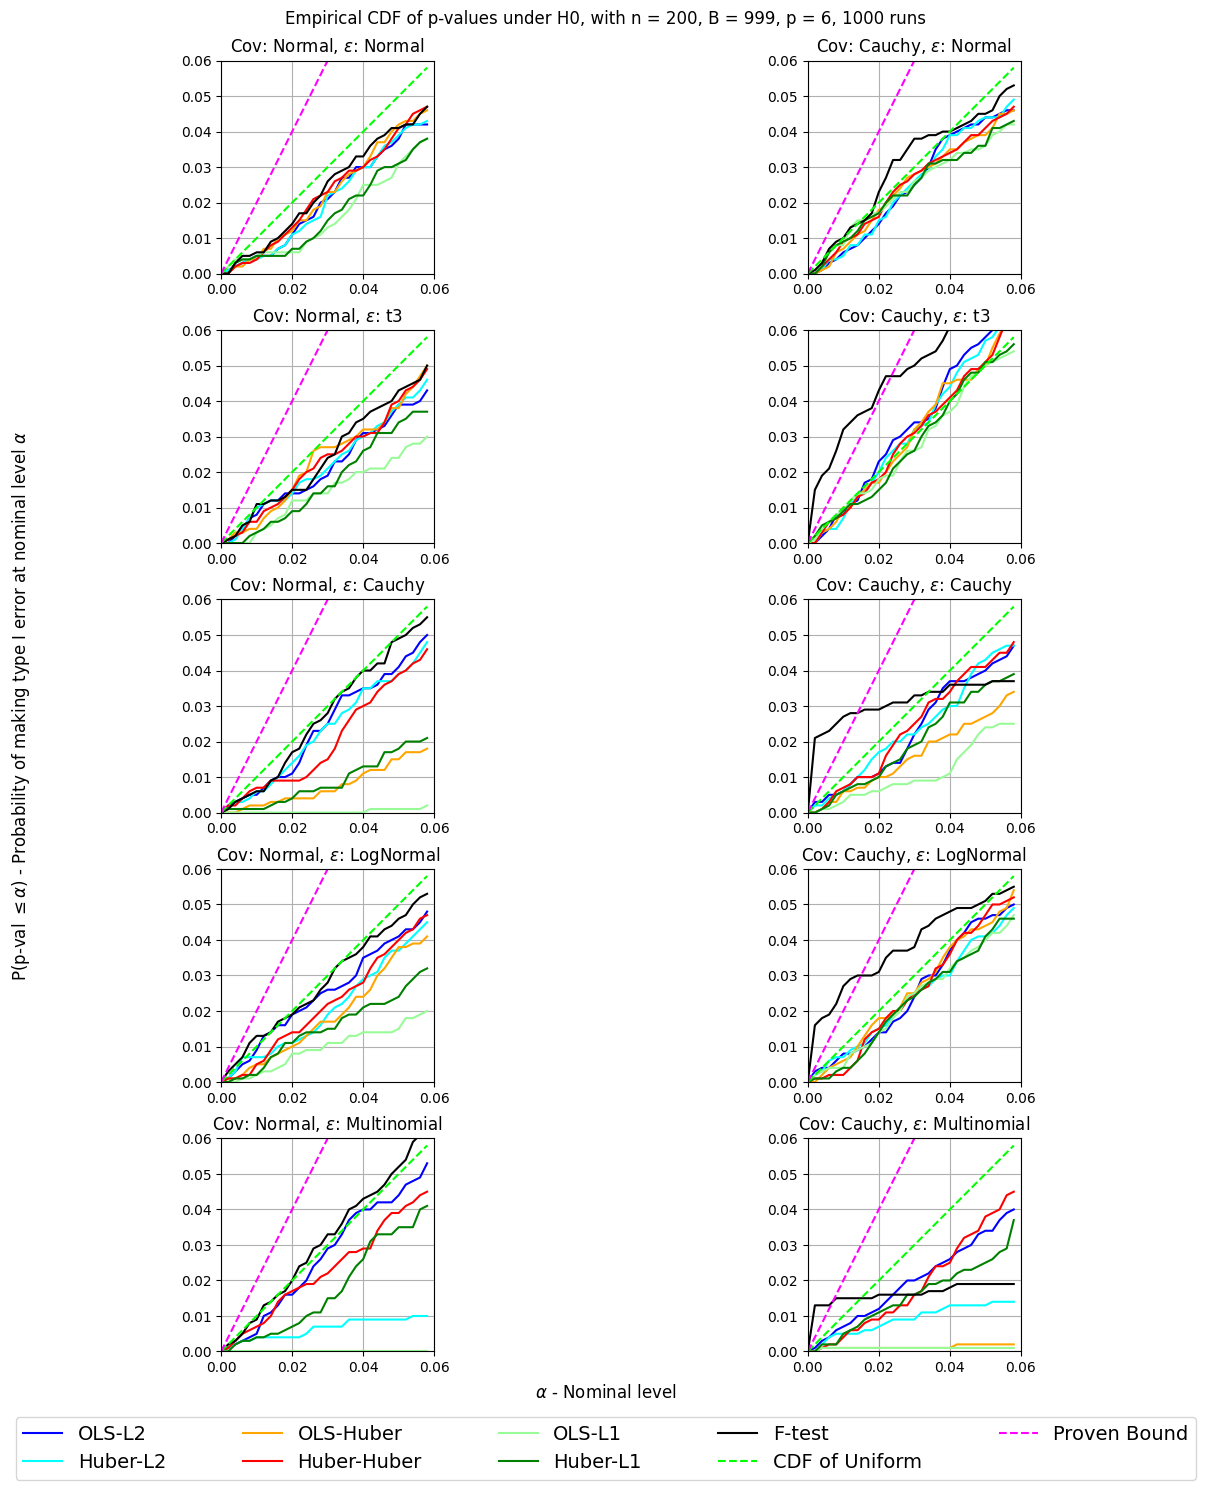

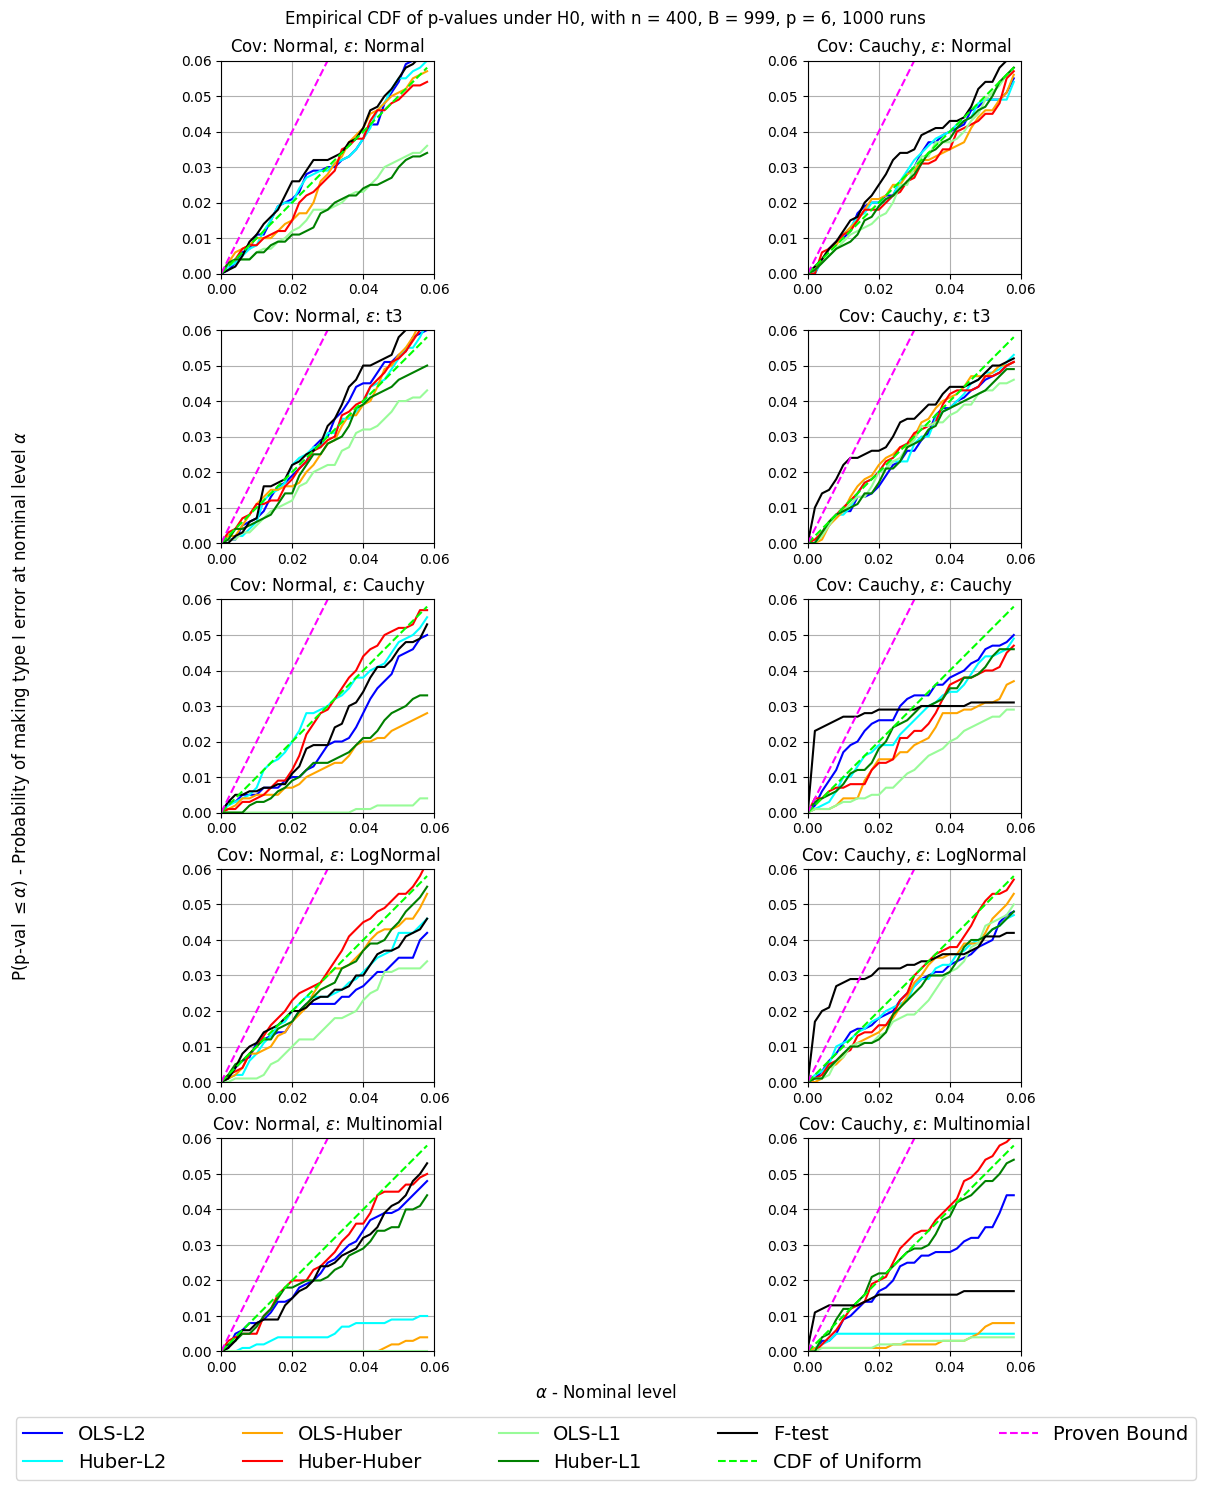

In [6]:
################################################
# Create the sample size experiment empirical CDF plots
################################################

# Type I error rate by sample size n

for n in [25, 50, 200, 400]:
    fig = plt.figure(layout="constrained", figsize = (12, 14))
    axs = fig.subplots(nrows = 5, ncols = 2)

    fig.supxlabel("$\\alpha$ - Nominal level")
    fig.supylabel("P(p-val $\leq \\alpha$) - Probability of making type I error at nominal level $\\alpha$")
    fig.suptitle(f"Empirical CDF of p-values under H0, with n = {n}, B = 999, p = 6, 1000 runs")


    def plot_sample_size_typeI_cell(ax, cov, eps, n):
        cov_mask = sample_size_df["cov"] == cov
        eps_mask = sample_size_df["eps"] == eps
        target_mask = sample_size_df["target"] == 0
        n_mask = sample_size_df["n"] == n

        df = sample_size_df[cov_mask & eps_mask & target_mask & n_mask][plot_methods + ["F-test"]]

        M = 500
        indices = np.arange(M) / M

        max_alpha = 0.06

        trials_plotting_count = int(M * max_alpha)
        plot_mask = np.arange(trials_plotting_count)

        for col in df:
            empirical_cdf = (df[col].to_numpy().reshape(1, -1) <= indices.reshape(-1, 1)).mean(axis = 1)
            ax.plot(
                indices[plot_mask],
                empirical_cdf[plot_mask],
                label = col,
                color = colors_dict[col]
            )
        ax.plot(indices[plot_mask], indices[plot_mask], "--", color = "lime", label = "CDF of Uniform")
        ax.plot(indices[plot_mask], indices[plot_mask] * 2, "--", color = "fuchsia", label = "Proven Bound")

        ax.grid(True)
        ax.set_xlim(0.0, max_alpha)
        ax.set_ylim(0.0, max_alpha)
        ax.set_aspect("equal")

        ax.set_title(f"Cov: {cov}, $\\epsilon$: {eps}")

        
    for i, (cov, eps) in enumerate(designs):
        row = i % 5
        col = i // 5
        plot_sample_size_typeI_cell(axs[row][col], cov, eps, n)

    # Create the legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, mode = "expand", ncols = 5, 
        loc = "lower left", bbox_to_anchor = (0., -0.06, 1., 1.), fontsize = 14)

    # Save the figure
    fig.savefig(f"./images/sim_n{n}_typeI.eps", dpi = 800, bbox_inches = "tight")
